# GitOps Flow with MLRun

In [1]:
# !pip install s3fs

## Setup Project

In [2]:
import os
import json

from src import create_and_set_project
from config import AppConfig
from dotenv import load_dotenv

load_dotenv("secrets.env")

config = AppConfig()

project = create_and_set_project(
    name=config.project_name,
    source=config.archive_source,
    secrets_file=config.secrets_file,
    artifact_path=config.artifact_path,
    default_image="nschenone/mlrun-cicd:1.5.0",
    force_build=True
)

> 2024-05-14 23:17:10,865 [info] Server and client versions are not the same but compatible: {'parsed_server_version': Version(major=1, minor=6, patch=1, prerelease=None, build=None), 'parsed_client_version': Version(major=1, minor=5, patch=0, prerelease=None, build=None)}
> 2024-05-14 23:17:10,999 [info] Project loaded successfully: {'project_name': 'cicd-flow'}
Exporting project as zip archive to v3io:///bigdata/cicd-flow.zip...


Passing a requirements file path as a string in the 'requirements' argument is deprecated and will be removed in 1.6.0, use 'requirements_file' instead
Passing a requirements file path as a string in the 'requirements' argument is deprecated and will be removed in 1.6.0, use 'requirements_file' instead


## Run Training Pipeline

In [3]:
train_config = config.get_workflow_config(workflow_name="train")

In [4]:
project.notifiers.add_notification(notification_type="slack", params={"webhook": os.getenv("SLACK_WEBHOOK_URL")})

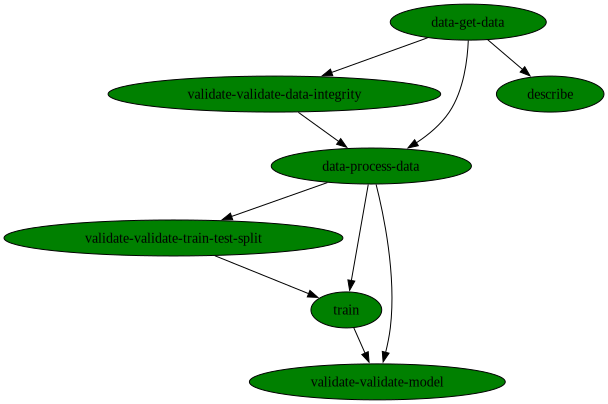

uid,start,state,name,parameters,results
...f331111a,May 14 23:21:04,completed,validate-validate-model,model_path=store://artifacts/cicd-flow/model:5215e9af-19dd-43ee-9e67-5e0d5d31477elabel_column=targetallow_validation_failure=True,passed_suite=False
...0ceb2983,May 14 23:20:10,completed,train,label_column=target,best_iteration=3accuracy=0.8771929824561403f1_score=0.8771929824561403precision_score=0.8333333333333334recall_score=0.9259259259259259
...45d00b12,May 14 23:19:41,completed,validate-validate-train-test-split,label_column=targetallow_validation_failure=True,passed_suite=False
...338a1b42,May 14 23:19:19,completed,data-process-data,"label_column=targettest_size=0.2ohe_columns=['sex', 'cp', 'slope', 'thal', 'restecg']",
...ab68bcbc,May 14 23:18:19,completed,describe,label_column=target,
...7dfd785e,May 14 23:18:19,completed,validate-validate-data-integrity,label_column=targetallow_validation_failure=True,passed_suite=True
...45503516,May 14 23:17:57,completed,data-get-data,,


In [5]:
run_id = project.run(
    name="train",
    arguments=train_config,
    dirty=True,
    watch=True
)

## Run Deployment Pipeline

In [6]:
deploy_config = config.get_workflow_config(workflow_name="deploy")

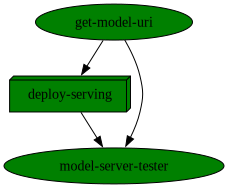

uid,start,state,name,parameters,results
...dcfe230b,May 14 23:23:41,completed,model-server-tester,addr=http://cicd-flow-serving-cicd-flow.default-tenant.app.cst-354.iguazio-cd2.com/label_column=targetmodel=model,total_tests=20errors=0match=9avg_latency=83287min_latency=80176max_latency=103435
...bb72a02a,May 14 23:21:53,completed,get-model-uri,model_name=modelmodel_tag=challenger,model_uri=store://models/cicd-flow/model#0:challengertest_set_uri=s3://iguazio-demo/projects/cicd-flow/artifacts/ed8423cc-69e1-4929-a749-44339e2535bb/train/1/test_set.parquet


In [7]:
run_id = project.run(
    name="deploy",
    arguments=deploy_config,
    dirty=True,
    watch=True
)

### Invoke Model

In [8]:
# Get serving function
serving_fn = project.get_function("serving")
model_name = config.deploy_model_name
label_column = config.label_column

# Get test set
df = project.get_artifact("data-process-data_test").to_dataitem().as_df()
display(df.head())

# Transform to list
# Get training set as list
data = df.drop(label_column, axis=1).to_dict(orient="split")["data"]

,sex_female,sex_male,cp_asymtomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,...,restecg_st-t_wave_abnormality,age,exang,fbs,trestbps,chol,thalach,oldpeak,ca,target
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,54.0,1.0,0.0,122.0,286.0,116.0,3.2,2.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,58.0,1.0,0.0,128.0,216.0,131.0,2.2,3.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,54.0,0.0,0.0,150.0,232.0,165.0,1.6,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,60.0,1.0,0.0,130.0,206.0,132.0,2.4,2.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,62.0,0.0,0.0,124.0,209.0,163.0,0.0,0.0,1.0


In [9]:
serving_fn.invoke(
    f"v2/models/{model_name}/infer", json.dumps({"inputs": data[:5]})
)

> 2024-05-14 23:24:11,828 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-cicd-flow-serving.default-tenant.svc.cluster.local:8080/v2/models/model/infer'}


{'id': '8ae5d0f0-727a-4222-ba62-1d7d3d09ae0a',
 'model_name': 'model',
 'outputs': [0.0, 0.0, 1.0, 0.0, 1.0]}

### Simulate Traffic

MLRun real-time drift detection requires 10,000 events

In [10]:
import json
import logging
from random import choice

from tqdm.notebook import tqdm

# Suppress print messages
logging.getLogger(name="mlrun").setLevel(logging.WARNING)

# Simulate traffic using random elements from training set
for i in tqdm(range(10)):
    data_point = choice(data)
    resp = serving_fn.invoke(
        f"v2/models/{model_name}/infer", json.dumps({"inputs": [data_point]})
    )
    print(resp)

# Resume normal logging
logging.getLogger(name="mlrun").setLevel(logging.INFO)

  0%|          | 0/10 [00:00<?, ?it/s]

{'id': '767338e8-49a2-4e24-922d-a4cfe639ab52', 'model_name': 'model', 'outputs': [1.0]}
{'id': '89299c3e-f8cd-492c-925f-ad6c90e20c6b', 'model_name': 'model', 'outputs': [1.0]}
{'id': '4e520638-623c-4958-86e7-acd7c561c104', 'model_name': 'model', 'outputs': [0.0]}
{'id': '77710c85-cebe-4c8d-a66e-29f7efa43d39', 'model_name': 'model', 'outputs': [1.0]}
{'id': 'f5a2556b-1180-43a5-81b9-26d744ae7262', 'model_name': 'model', 'outputs': [0.0]}
{'id': '3c9c7254-aa10-49dc-bd94-c6f24a1d9680', 'model_name': 'model', 'outputs': [0.0]}
{'id': 'ff767bc5-e151-449b-9f45-25e4af91d877', 'model_name': 'model', 'outputs': [0.0]}
{'id': '56d31e5e-c711-4183-affa-12d4262c41b0', 'model_name': 'model', 'outputs': [1.0]}
{'id': '5b3a913f-50a1-4aa9-aa37-d2e9134ab654', 'model_name': 'model', 'outputs': [0.0]}
{'id': '799abc6f-82ec-49d5-b885-012a70b10f2e', 'model_name': 'model', 'outputs': [0.0]}
